# Comperhinve Guide to Time Series Data Manipulating In Python


Time series data is one of the most common data types in the industry and you will probably be working with it in your career. Therefore understanding how to work with it and how to apply analytical and forecasting techniques are critical for every aspiring data scientist. In this series of articles, I will go through the basic techniques to work with time-series data, starting from data manipulation, analysis, and visualization to understand your data and prepare it for and then using a statistical, machine, and deep learning techniques for forecasting and classification. It will be more of a practical guide in which I will be applying each discussed and explained concept to real data.

## Table of content:
1. Working with Time Series in Pandas
2. Basic Time Series Metrics & Resampling
3. Window Functions: Rolling & Expanding Metrics
4. Building a value-weighted index

# 1. Working with Time Series in Pandas
This section lays the foundations to leverage the powerful time-series functionality made available by how Pandas represents dates, in particular by the DateTimeIndex. You will learn how to create and manipulate date information and time series, and how to do calculations with time-aware DataFrames to shift your data in time or create period-specific returns.

## 1.1. How to use data and times with pandas
The basic building block of creating a time series data in python using Pandas time stamp (pd.Timestamp) is shown in the example below:

In [1]:
import pandas as pd 
from datetime import datetime # To manually create dates
import matplotlib.pyplot as plt
time_stamp = pd.Timestamp(datetime(2017, 1, 1))


The timestamp object has many attributes that can be used to retrieve specific time information of your data such as year, and weekday. In the example below the year of the data is retrieved.

In [2]:
time_stamp.year


2017

The second building block is the period object. The period object has a freq attribute to store the frequency information. The default is monthly freq and you can convert from freq to another as shown in the example below.

In [3]:
period = pd.Period('2017-01')
period

Period('2017-01', 'M')

The output shows that the default freq is monthly freq. You can convert it into a daily freq using the code below.


In [4]:
period.asfreq('D') # convert to daily

Period('2017-01-31', 'D')

You can also convert period to timestamp and vice versa. This is shown in the example below:


In [5]:
period.to_timestamp().to_period('M')


Period('2017-01', 'M')

You can do basic data arithmetic operations, for example starting with a period object for January 2017 at a monthly frequency, just add the number 2 to get a monthly period for March 2017. This is shown in the example below.

In [6]:
period = pd.Period('2017-01')
period+2

Period('2017-03', 'M')

To create a time series you will need to create a sequence of dates. To create a sequence of Timestamps, use the pandas' function date_range. You need to specify a start date, and/or end date, or a number of periods. The default is daily frequency. The function returns the sequence of dates as a DateTimeindex with frequency information. You will recognize the first element as a pandas Timestamp.

This is shown in the example below and the output is shown in the figure below:



In [7]:
index = pd.date_range(start='2017-1-1', periods=12, freq='M')
index


DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

## 1.2. Indexing & resampling time series

The basic transformations include parsing dates provided as strings and converting the result into the matching Pandas data type called datetime64. They also include selecting subperiods of your time series, and setting or changing the frequency of the DateTimeIndex. You can change the frequency to a higher or lower value: upsampling involves increasing the time frequency, which requires generating new data. Downsampling means decreasing the time-frequency, which requires aggregating data.

To understand more about the transformations we will apply this to the google stock prices data. First, if you check the type of the date column it is an object, so we would like to convert it into a date type by the following code.



In [8]:
google = pd.read_csv('/kaggle/input/google/google.csv') # import pandas as pd
google.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1094 non-null   object 
 1   Close   756 non-null    float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


The date information is converted from a string (object) into a datetime64 and also we will set the Date column as an index for the data frame as it makes it easier that to deal with the data by using the following code:

In [9]:
google.Date = pd.to_datetime(google.Date)
google.set_index('Date', inplace=True)
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2014-01-02 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   756 non-null    float64
dtypes: float64(1)
memory usage: 17.1 KB


To have a better intuition of what the data looks like, let's plot the prices with time using the code below:


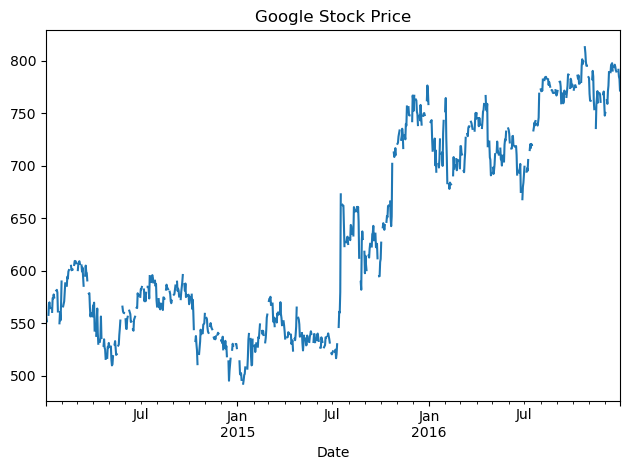

In [10]:
google.Close.plot(title='Google Stock Price')
plt.tight_layout(); plt.show()


You can also partial indexing the data using the date index as the following example:



In [11]:
google['2015'].info() # Pass string for part of date


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [12]:
google['2015-3': '2016-2'].info() # Slice includes last month


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2015-03-01 to 2016-02-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


You may have noticed that our DateTimeIndex did not have frequency information. You can set the frequency information using dot-asfreq. The alias ‘D’ stands for calendar day frequency. As a result, the DateTimeIndex now contains many dates where the stock wasn’t bought or sold.

The example below shows converting the DateTimeIndex of the google stock data into calendar day frequency:

In [13]:
google.asfreq('D').info() # set calendar day frequency

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2014-01-02 to 2016-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   756 non-null    float64
dtypes: float64(1)
memory usage: 17.1 KB


The number of instances has increased to 756 due to this daily sampling. The code below prints the first five rows of the daily resampled data:



In [14]:
google.asfreq('D').head()

,Close
Date,
2014-01-02,556.00
2014-01-03,551.95
2014-01-04,NaN
2014-01-05,NaN
2014-01-06,558.10


## 1.3. Lags, changes, and returns for stock price series

Shift or lag values back or forward back in time. shift(): Moving data between past & future. The default is one period into the future, but you can change it, by giving the periods variable the desired shift value.

An example of the shift method is shown below:



In [15]:
google['shifted'] = google.Close.shift() # default: periods=1
google.head(3)


,Close,shifted
Date,,
2014-01-02,556.00,NaN
2014-01-03,551.95,556.00
2014-01-04,NaN,551.95


To move the data into the past you can use periods=-1 as shown in the figure below:


In [16]:
google['lagged'] = google.Close.shift(periods=-1)
google[['Close', 'lagged', 'shifted']].tail(3)

,Close,lagged,shifted
Date,,,
2016-12-28,785.05,782.79,791.55
2016-12-29,782.79,771.82,785.05
2016-12-30,771.82,NaN,782.79


One of the important properties of the stock prices data and in general in the time series data is the percentage change. It’s formula is : ((X(t)/X(t-1))-1)*100.

There are two ways to calculate it, we can use the built-in function df.pct_change() or use the functions df.div.sub().mul() and both will give the same results as shown in the example below:


In [17]:
google['change'] = google.Close.div(google.shifted)
google['return'] = google.change.sub(1).mul(100)
google[['Close', 'shifted', 'change','return']].head(3)

,Close,shifted,change,return
Date,,,,
2014-01-02,556.00,NaN,NaN,NaN
2014-01-03,551.95,556.00,0.992716,-0.728417
2014-01-04,NaN,551.95,NaN,NaN


In [18]:
google['pct_change'] = google.Close.pct_change().mul(100)
google[['Close', 'return', 'pct_change']].head(3)


,Close,return,pct_change
Date,,,
2014-01-02,556.00,NaN,NaN
2014-01-03,551.95,-0.728417,-0.728417
2014-01-04,NaN,NaN,0.000000


We can also get multiperiod returns using the periods variable in the df.pct_change() method as shown in the following example.


In [19]:
google['return_3d'] = google.Close.pct_change(periods=3).mul(100)
google[['Close', 'return_3d']].head()

,Close,return_3d
Date,,
2014-01-02,556.00,NaN
2014-01-03,551.95,NaN
2014-01-04,NaN,NaN
2014-01-05,NaN,-0.728417
2014-01-06,558.10,1.114231


# 2. Basic Time Series Metrics & Resampling

In this section, we will dive deeper into the essential time-series functionality made available through the pandas DataTimeIndex. we will introduce resampling and how to compare different time series by normalizing their start points.

## 2.1. Resampling
We will start with resampling which is changing the frequency of the time series data. This is a very common operation because you often need to convert two-time series to a common frequency to analyze them together. When you upsample by converting the data to a higher frequency, you create new rows and need to tell pandas how to fill or interpolate the missing values in these rows. When you downsample, you reduce the number of rows and need to tell pandas how to aggregate existing data.

To illustrate what happens when you up-sample your data, let’s create a Series at a relatively low quarterly frequency for the year 2016 with the integer values 1–4. When you choose a quarterly frequency, pandas default to December for the end of the fourth quarter, which you could modify by using a different month with the quarter alias.

In [20]:
# Creating Quarterly data
dates = pd.date_range(start='2016', periods=4, freq='Q')
data = range(1, 5)
quarterly = pd.Series(data=data, index=dates)
quarterly

2016-03-31    1
2016-06-30    2
2016-09-30    3
2016-12-31    4
Freq: Q-DEC, dtype: int64

Next, let’s see what happens when you up-sample your time series by converting the frequency from quarterly to monthly using **dot-asfreq()**. Pandas add new month-end dates to the DateTimeIndex between the existing dates. As a result, there are now several months with missing data between March and December.

In [21]:
monthly = quarterly.asfreq('M') # to month-end frequency
monthly = monthly.to_frame('baseline') # to DataFrame
monthly

,baseline
2016-03-31,1.0
2016-04-30,NaN
2016-05-31,NaN
2016-06-30,2.0
2016-07-31,NaN
2016-08-31,NaN
2016-09-30,3.0
2016-10-31,NaN
2016-11-30,NaN
2016-12-31,4.0


Let’s compare three ways that pandas offer to fill missing values when upsampling. The first two options involve choosing a fill method, either forward fill or backfill. The third option is to provide full value.

In [22]:
# Differnet Upsampling fill methods
monthly['ffill'] = quarterly.asfreq('M', method='ffill') # bfill back fill
monthly['bfill'] = quarterly.asfreq('M', method='bfill') # ffill : forward fill
monthly['value'] = quarterly.asfreq('M', fill_value=0)
monthly

,baseline,ffill,bfill,value
2016-03-31,1.0,1,1,1
2016-04-30,NaN,1,2,0
2016-05-31,NaN,1,2,0
2016-06-30,2.0,2,2,2
2016-07-31,NaN,2,3,0
2016-08-31,NaN,2,3,0
2016-09-30,3.0,3,3,3
2016-10-31,NaN,3,4,0
2016-11-30,NaN,3,4,0
2016-12-31,4.0,4,4,4


If you compare the results, you see that forward fill propagates any value into the future if the future contains missing values. Backfill does the same for the past, and fill_value just substitutes missing values.

If you want a monthly DateTimeIndex that covers the full year, you can use dot-reindex. Pandas align existing data with the new monthly values and produce missing values elsewhere. You can use the exact same fill options for dot-reindex as you just did for dot-asfreq.

In [23]:
# using reindex 
dates = pd.date_range(start='2016', periods=12, freq='M')
quarterly.reindex(dates)

2016-01-31    NaN
2016-02-29    NaN
2016-03-31    1.0
2016-04-30    NaN
2016-05-31    NaN
2016-06-30    2.0
2016-07-31    NaN
2016-08-31    NaN
2016-09-30    3.0
2016-10-31    NaN
2016-11-30    NaN
2016-12-31    4.0
Freq: M, dtype: float64

## 2.2. Upsampling & interpolation

The resample method follows a logic similar to dot-groupby: It groups data within a resampling period and applies a method to this group. It takes the value that results from this method and assigns a new date within the resampling period. The new date is determined by a so-called offset, and for instance, can be at the beginning or end of the period or a custom location. You will use resample to apply methods that either fill or interpolate missing dates when up-sampling, or that aggregate when down-sampling.

We will apply the resample method to the monthly unemployment rate. First, we will upload it and spare it using the DATE column and make it an index.

In [24]:
unrate = pd.read_csv('/kaggle/input/unrate/unrate.csv', parse_dates=['DATE'], index_col='DATE')
unrate.head()

,UNRATE
DATE,
2010-01-01,9.8
2010-02-01,9.8
2010-03-01,9.9
2010-04-01,9.9
2010-05-01,9.6


The 85 data points imported using read_csv since 2010 have no frequency information. An inspection of the first rows shows that the data are reported for the first of each calendar month. So let's resample it by the starting of each calendar month using both **dot-resample** and **dot-asfreq** methods.

In [25]:
unrate.asfreq('MS').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2010-01-01 to 2017-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [26]:
unrate.resample('MS') # creates Resampler object
unrate.asfreq('MS').equals(unrate.resample('MS').asfreq())

True

Both of the methods are the same. When looking at resampling by month, we have so far focused on month-end frequency. In other words, after resampling, new data will be assigned the last calendar day for each month. There are, however, quite a few alternatives as shown in the table below:

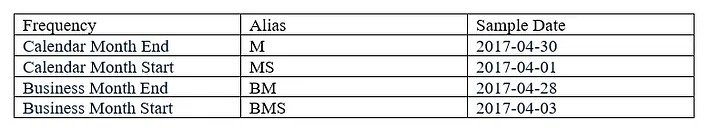


Depending on your context, you can resample to the beginning or end of either the calendar or business month.

Resampling implements the following logic: When up-sampling, there will be more resampling periods than data points. Each resampling period will have a given date offset, for instance, month-end frequency. You then need to decide how to create data for the new resampling periods. The new data points will be assigned to the date offsets. In contrast, when down-sampling, there are more data points than resampling periods. Hence, you need to decide how to aggregate your data to obtain a single value for each date offset.

Let’s now use a quarterly series, real GDP growth. You see that there is again no frequency info, but the first few rows confirm that the data are reported for the first day of each quarter.


In [27]:
# Upload the GDP growth
gdp = pd.read_csv('/kaggle/input/gdp-growth/gdp_growth.csv', parse_dates=['date'], index_col='date')
gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2007-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gdp_growth  41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes


Resample also lets you interpolate the missing values, that is, fill in the values that lie on a straight line between existing quarterly growth rates. A look at the first few rows shows how to interpolate the average's existing values.

In [28]:
gdp_2 = gdp.resample('MS').interpolate().add_suffix('_inter')
gdp_2.head()

,gdp_growth_inter
date,
2007-01-01,0.200000
2007-02-01,1.166667
2007-03-01,2.133333
2007-04-01,3.100000
2007-05-01,2.966667


We’ll now combine the two series using the pandas dot-concat function to concatenate the two data frames. Using axis=1 makes pandas concatenate the DataFrames horizontally, aligning the row index. A plot of the data for the last two years visualizes how the new data points lie on the line between the existing points, whereas forward filling creates a step-like pattern.

<AxesSubplot:xlabel='date'>

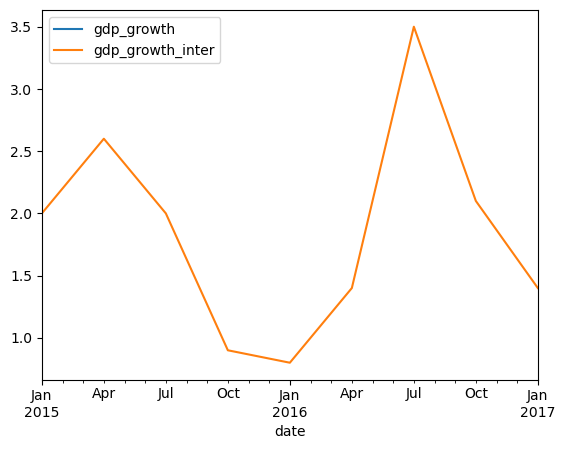

In [29]:
# Plot interpolated real GDP growth
pd.concat([gdp, gdp_2], axis=1).loc['2015':].plot()

After resampling GDP growth, you can plot the unemployment and GDP series based on their common frequency.

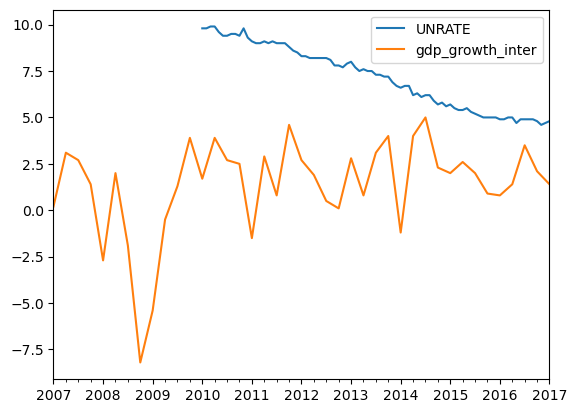

In [30]:
#Combine GDP growth & unemployment
pd.concat([unrate, gdp_2], axis=1).loc['2007':].plot();

## 2.3. Downsampling & aggregation

So far, we have focused on up-sampling, that is, increasing the frequency of a time series, and how to fill or interpolate any missing values. Downsampling is the opposite, is how to reduce the frequency of the time series data. This includes, for instance, converting hourly data to daily data, or daily data to monthly data. In this case, you need to decide how to summarize the existing data as 24 hours becomes a single day. Your options are familiar aggregation metrics like the mean or median, or simply the last value and your choice will depend on the context.

Let’s first use read_csv to import air quality data from the Environmental Protection Agency. It contains the average daily ozone concentration for New York City starting in 2000. Since the imported DateTimeIndex has no frequency, let’s first assign calendar day frequency using dot-resample. The resulting DateTimeIndex has additional entries, as well as the expected frequency information.



In [31]:
ozone = pd.read_csv('/kaggle/input/ozone-nyc/ozone_nyc.csv', parse_dates=['date'], index_col='date')
ozone.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB


In [32]:
ozone = ozone.resample('D').asfreq()
ozone.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.4 KB


To convert daily ozone data to monthly frequency, just apply the resample method with the new sampling period and offset. We are choosing monthly frequency with default month-end offset. Next, apply the mean method to aggregate the daily data to a single monthly value. You can see that the monthly average has been assigned to the last day of the calendar month.

In [33]:
ozone.resample('M').mean().head()


,Ozone
date,
2000-01-31,0.010443
2000-02-29,0.011817
2000-03-31,0.016810
2000-04-30,0.019413
2000-05-31,0.026535


You can apply the median in the exact same fashion


In [34]:
ozone.resample('M').median().head()

,Ozone
date,
2000-01-31,0.009486
2000-02-29,0.010726
2000-03-31,0.017004
2000-04-30,0.019866
2000-05-31,0.026018


Similar to the groupby method, you can also apply multiple aggregations at once.

In [35]:
ozone.resample('M').agg(['mean', 'std']).head()

Ozone          
                mean       std
date                          
2000-01-31  0.010443  0.004755
2000-02-29  0.011817  0.004072
2000-03-31  0.016810  0.004977
2000-04-30  0.019413  0.006574
2000-05-31  0.026535  0.008409

Let’s visualize the resampled, aggregated Series relative to the original data at calendar-daily frequency. We’ll plot the data starting from 2016 so you can see more detail. Matplotlib allows you to plot several times on the same object by referencing the axes object that contains the plot.


<AxesSubplot:xlabel='date'>

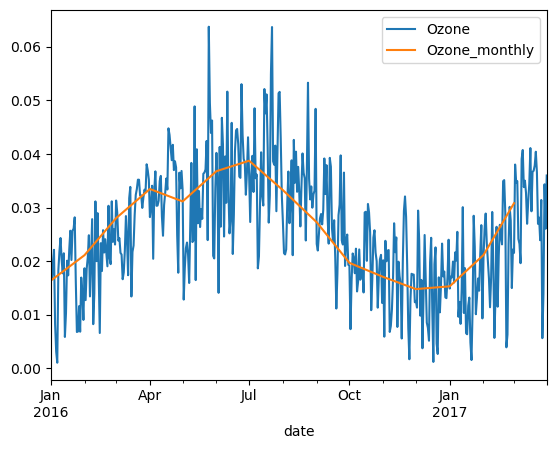

In [36]:
ozone = ozone.loc['2016':]
ax = ozone.plot()
monthly = ozone.resample('M').mean()
monthly.add_suffix('_monthly').plot(ax=ax)

The first plot is the original series, and the second plot contains the resampled series with a suffix so that the legend reflects the difference. You see that the resampled data are much smoother since the monthly volatility has been averaged out. Let’s also take a look at how to resample several series.

# 3. Window Functions: Rolling & Expanding Metrics
In this section, we will show you how to use the window function to calculate time series metrics for both rolling and expanding windows.

## 3.1. Window functions with pandas
Window functions are useful because they allow you to operate on sub-periods of your time series. In particular, window functions calculate metrics for the data inside the window. Then, the result of this calculation forms a new time series, where each data point represents a summary of several data points of the original time series. We will discuss two main types of windows: Rolling windows maintain the same size while they slide over the time series, so each new data point is the result of a given number of observations. Expanding windows grow with the time series so that the calculation that produces a new data point is the result of all previous data points.

Let’s calculate a simple moving average to see how this works in practice. We will again use google stock price data for the last several years. We will see two ways to define the rolling window:

First, we apply rolling with an integer window size of 30. This means that the window will contain the previous 30 observations or trading days. When you choose an integer-based window size, pandas will only calculate the mean if the window has no missing values. You can change this default by setting the min_periods parameter to a value smaller than the window size of 30.

In [37]:
# Integer-based window size
ozone.rolling(window=30, min_periods=1).mean() # fixed # observations

,Ozone
date,
2016-01-01,0.023206
2016-01-02,0.020030
2016-01-03,0.019516
2016-01-04,0.020166
2016-01-05,0.017789
...,...
2017-03-27,0.030317
2017-03-28,0.029861
2017-03-29,0.030507


You can also create windows based on a date offset. If you choose 30D, for instance, the window will contain the days when stocks were traded during the last 30 calendar days. While the window is fixed in terms of period length, the number of observations will vary. Let’s take a look at what the rolling mean looks like.

In [38]:
# Offset-based window size
ozone.rolling(window='30D').mean() # fixed period length

,Ozone
date,
2016-01-01,0.023206
2016-01-02,0.020030
2016-01-03,0.019516
2016-01-04,0.020166
2016-01-05,0.017789
...,...
2017-03-27,0.030317
2017-03-28,0.029861
2017-03-29,0.030507


You can also calculate a 90 calendar day rolling mean, and join it to the stock price. The join method allows you to concatenate a Series or DataFrame along axis 1, that is, horizontally. It’s just a different way of using the dot-concat function you’ve seen before. You can see how the new time series is much smoother because every data point is now the average of the preceding 90 calendar days.

<AxesSubplot:xlabel='date'>

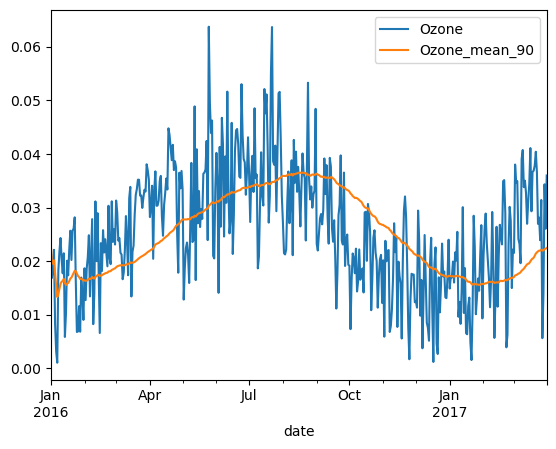

In [39]:
r90 = ozone.rolling(window='90D').mean()
ozone.join(r90.add_suffix('_mean_90')).plot()

To see how extending the time horizon affects the moving average, let’s add the 360 calendar day moving average.

<AxesSubplot:xlabel='date'>

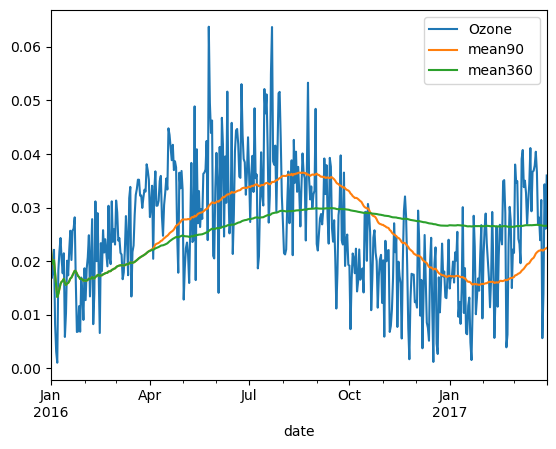

In [40]:
ozone['mean90'] = r90
r360 = ozone['Ozone'].rolling(window='360D').mean()
ozone['mean360'] = r360
ozone.plot()

The series now appears smoother still, and you can more clearly see when short-term trends deviate from longer-term trends, for instance when the 90-day average dips below the 360-day average in 2015.

Similar to dot-groupby, you can also calculate multiple metrics at the same time, using the dot-agg method. With a 90-day moving average and standard deviation, you can easily discern periods of heightened volatility.



array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

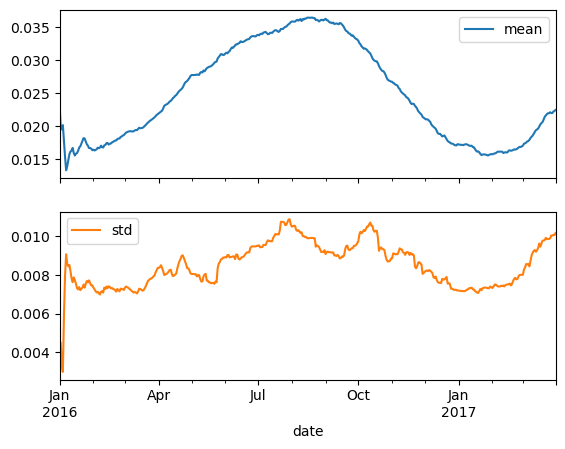

In [41]:
r = ozone.Ozone.rolling('90D').agg(['mean', 'std'])
r.plot(subplots = True)

Finally, let’s display a 360 calendar day rolling median, or 50 percent quantile, alongside the 10 and 90 percent quantiles. Again you can see how the ranges for the stock price have evolved over time, with some periods more volatile than others.

<AxesSubplot:xlabel='date'>

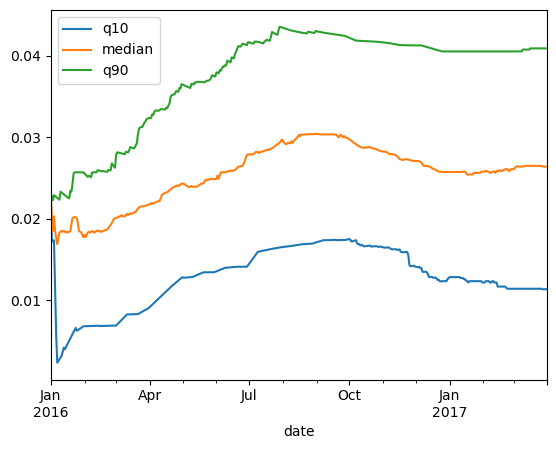

In [42]:
rolling = ozone.Ozone.rolling('360D')
q10 = rolling.quantile(0.1).to_frame('q10')
median = rolling.median().to_frame('median')
q90 = rolling.quantile(0.9).to_frame('q90')
pd.concat([q10, median, q90], axis=1).plot()

## 3.2. Expanding window functions with pandas

We will move from rolling to expanding windows. You will now calculate metrics for groups that get larger to exclude all data up to the current date. Each data point of the resulting time series reflects all historical values up to that point. Expanding windows are useful to calculate for instance a cumulative rate of return, or a running maximum or minimum. In pandas, you can use either the method expanding, which works just like rolling, or in a few cases shorthand methods for the cumulative sum, product, min, and max.

We will use the S&P500 data for the last ten years in the practical examples in this section. Let’s first take a look at how to calculate returns: The simple period return is just the current price divided by the last price minus 1. The return over several periods is the product of all period returns after adding 1 and then subtracting 1 from the product.

So for more clarification, the period return is: r(t) = (p(t)/p(t-1)) -1 and the multi-period return is: R(T) = (1+r(1))(1+r(2))……..(1+r(T)) — 1.

Pandas makes these calculations easy ‘ you have already seen the methods for percent change(.pct_change) and basic math (.diff(), .div(), .mul()), and now you’ll learn about the cumulative product.

To get the cumulative or running rate of return on the SP500, just follow the steps described above: Calculate the period return with percent change, and add 1 Calculate the cumulative product, and subtract one. You can multiply the result by 100, and plot the result in percentage terms. The code for this is shown below:

<AxesSubplot:xlabel='date'>

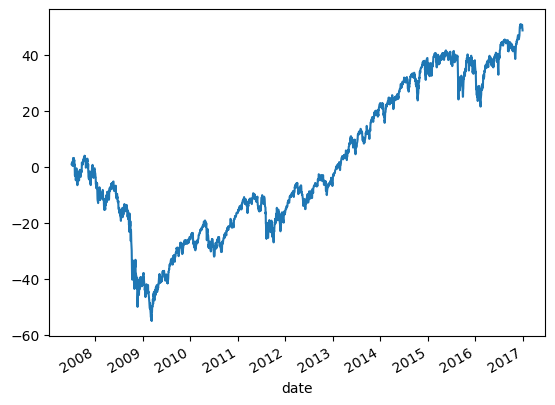

In [43]:
data = pd.read_csv('/kaggle/input/sp500-data/sp500.csv', parse_dates=['date'], index_col='date')
pr = data.SP500.pct_change() # period return
pr_plus_one = pr.add(1)
cumulative_return = pr_plus_one.cumprod().sub(1)
cumulative_return.mul(100).plot()

From the plot, we can see that the SP500 is up 60% since 2007, despite being down 60% in 2009. You can also easily calculate the running min and max of a time series: Just apply the expanding method and the respective aggregation method.

<AxesSubplot:xlabel='date'>

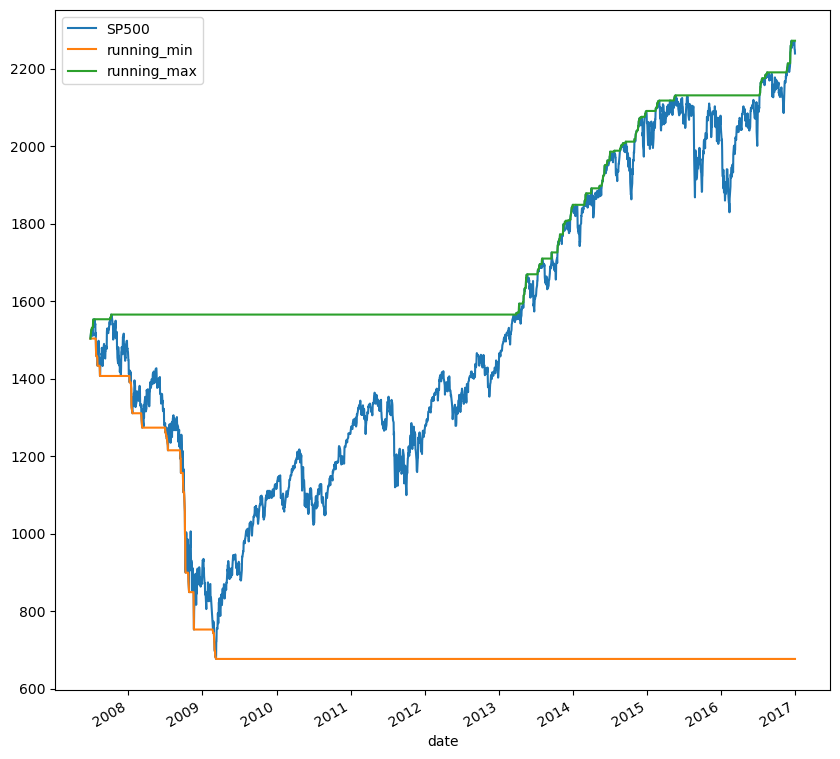

In [44]:
data['running_min'] = data.SP500.expanding().min()
data['running_max'] = data.SP500.expanding().max()
data.plot(figsize=(10,10))

The orange and green lines outline the min and max up to the current date for each day. You can also combine the concept of a rolling window with a cumulative calculation. Let’s calculate the rolling annual rate of return, that is, the cumulative return for all 360 calendar day periods over the ten-year period covered by the data. This cumulative calculation is not available as a built-in method. But no problem just define your own multiperiod function, and use apply it to run it on the data in the rolling window. The data in the rolling window is available to your multi_period_return function as a numpy array. Add 1 to increment all returns, apply the numpy product function, and subtract one to implement the formula from above. Just pass this function to apply after creating a 360 calendar day window for the daily returns. Multiply the rolling 1-year return by 100 to show them in percentage terms, and plot alongside the index using subplots equals True.

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

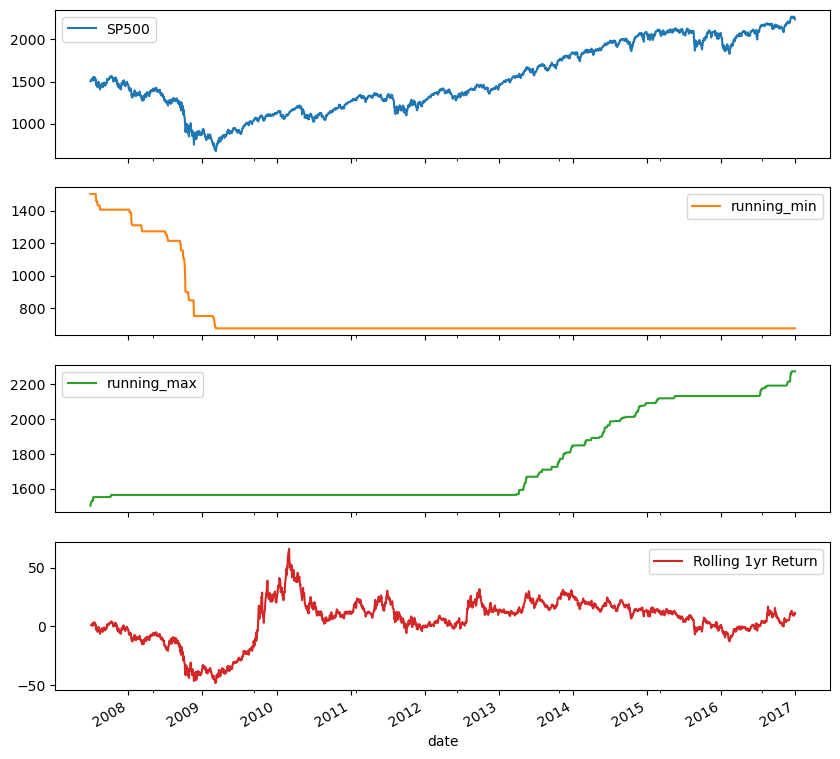

In [45]:
import numpy as np
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1
pr = data.SP500.pct_change() # period return
r = pr.rolling('360D').apply(multi_period_return)
data['Rolling 1yr Return'] = r.mul(100)
data.plot(subplots=True, figsize=(10,10))


The result shows the large annual return swings following the 2008 crisis.

## 3.4. Random walk and simulations

Daily stock returns are notoriously hard to predict, and models often assume they follow a random walk. We will use NumPy to generate random numbers, in a time series context. You’ll also use the cumulative product again to create a series of prices from a series of returns.

In the first example, we will generate random numbers from the bell-shaped normal distribution. This means that values around the average are more likely than extremes, as tends to be the case with stock returns. In the second example, you will randomly select actual S&P 500 returns to then simulate S&P 500 prices.

To generate random numbers, first import the normal distribution and the seed functions from numpy’s module random. Also, import the norm package from scipy to compare the normal distribution alongside your random samples. Generate 1000 random returns from numpy’s normal function, and divide by 100 to scale the values appropriately. Let’s plot the distribution of the 1,000 random returns, and fit a normal distribution to your sample. You can see that the sample closely matches the shape of the normal distribution.



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == "__main__":


<AxesSubplot:>

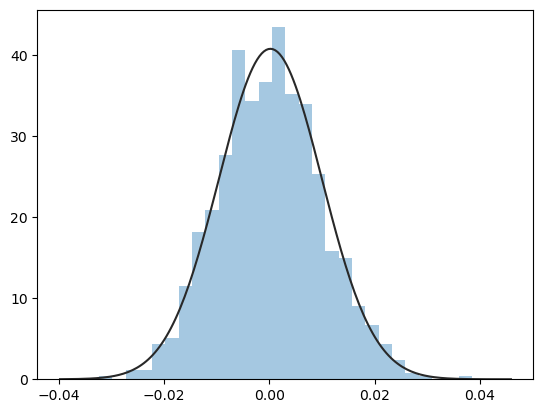

In [46]:
# Generate random numbers 
import seaborn as sns
from numpy.random import normal, seed
from scipy.stats import norm
import sys
seed(42)

random_returns = normal(loc=0, scale=0.01, size=1000)
sns.distplot(random_returns, fit=norm, kde=False)

To create a random price path from your random returns, we will follow the procedure from the subsection, after converting the numpy array to a pandas Series. Add 1 to the period returns, calculate the cumulative product, and subtract 1. Plot the cumulative returns, multiplied by 100, and you see the resulting prices.

<AxesSubplot:>

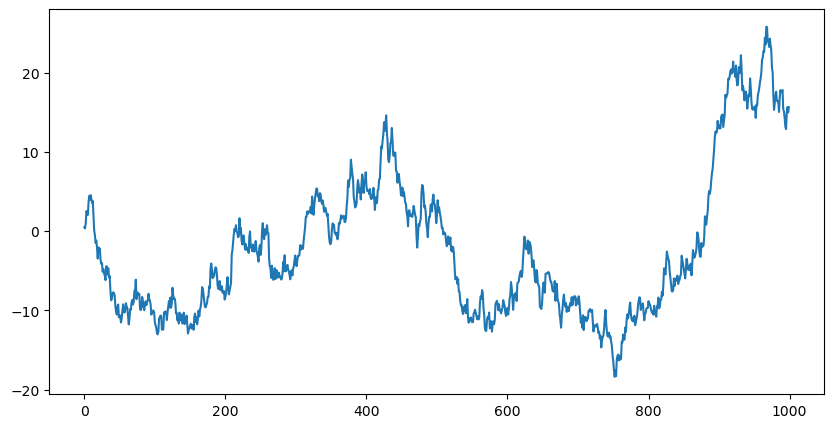

In [47]:
# Create a random price path
return_series = pd.Series(random_returns)
random_prices = return_series.add(1).cumprod().sub(1)
random_prices.mul(100).plot(figsize=(10,5))

Let’s now simulate the SP500 using a random expanding walk. Import the last 10 years of the index, drop missing values and add the daily returns as a new column to the DataFrame. A plot of the index and return series shows the typical daily return range between +/2–3 percent, as well as a few outliers during the 2008 crisis.

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

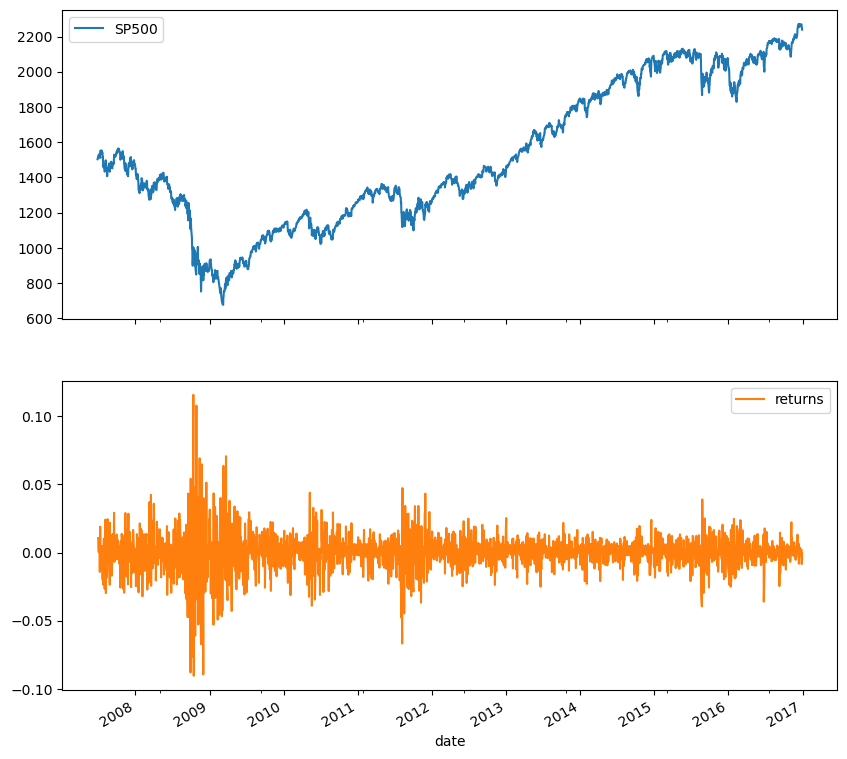

In [48]:
# S&P 500 prices & returns
data = pd.read_csv('/kaggle/input/sp500-data/sp500.csv', parse_dates=['date'], index_col='date')
data['returns'] = data.SP500.pct_change()
data.plot(subplots=True, figsize=(10,10))

A comparison of the S&P 500 return distribution to the normal distribution shows that the shapes don’t match very well. This is a typical finding ‘ daily stock returns tend to have outliers more often than the normal distribution would suggest.

Now let’s randomly select from the actual S&P 500 returns. You’ll be using the choice function from Numpy’s random module. It returns a NumPy array with a random sample from a list of numbers ‘ in our case, the S&P 500 returns. Just provide the return sample and the number of observations you want to the choice function. Next, convert the NumPy array to a pandas series, and set the index to the dates of the S&P 500 returns. Your random walk will start at the first S&P 500 price.

In [49]:
from numpy.random import choice

sample = data.returns.dropna()
n_obs = data.returns.count()
random_walk = choice(sample, size=n_obs)
random_walk = pd.Series(random_walk, index=sample.index)
random_walk.head()

date
2007-07-02    0.005007
2007-07-03    0.040729
2007-07-05   -0.000322
2007-07-06   -0.008404
2007-07-09    0.002119
dtype: float64

Use the ‘first’ method with calendar day offset to select the first S&P 500 price. Then add 1 to the random returns, and append the return series to the start value. Now you are ready to calculate the cumulative return given the actual S&P 500 start value. Add 1, calculate the cumulative product, and subtract one. The result is a random walk for the SP500 based on random samples from actual returns.

<AxesSubplot:xlabel='date'>

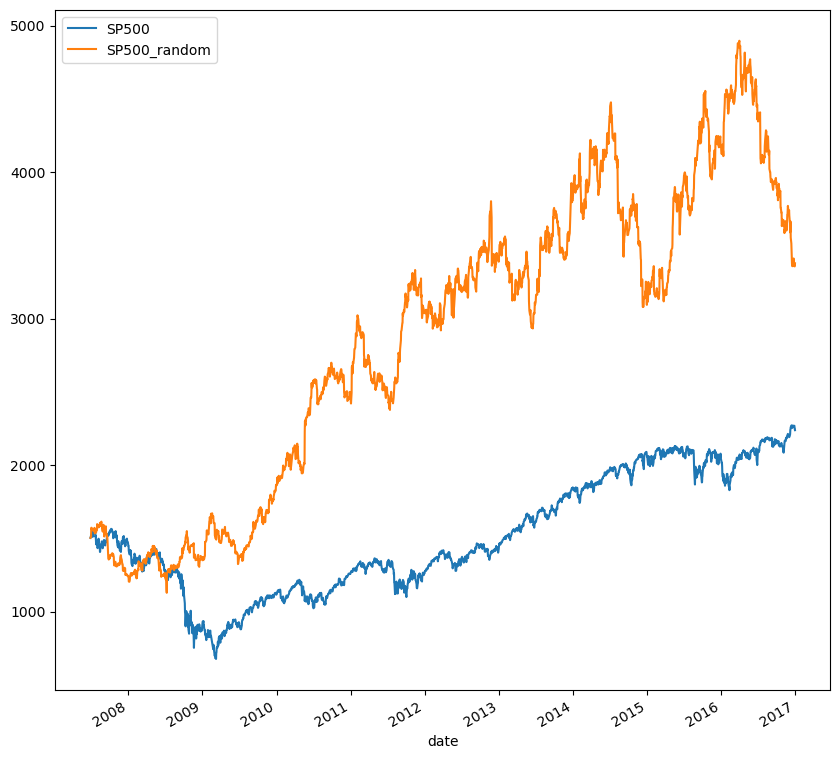

In [50]:
# Random S&P 500 prices 

start = data.SP500.first('D')
sp500_random = start.append(random_walk.add(1))
data['SP500_random'] = sp500_random.cumprod()
data[['SP500', 'SP500_random']].plot(figsize=(10,10))


## 3.4. Correlation between time series

Correlation is the key measure of linear relationships between two variables. In financial markets, correlations between asset returns are important for predictive models and risk management, for instance. Pandas and seaborn have various tools to help you compute and visualize these relationships.

The correlation coefficient looks at pairwise relations between variables and measures the similarity of the pairwise movements of two variables around their respective means. This pairwise co-movement is called covariance. The correlation coefficient divides this measure by the product of the standard deviations for each variable. As a result, the coefficient varies between -1 and +1. The closer the correlation coefficient to plus or 1 or minus 1, the more does a plot of the pairs of the two series resembles a straight line. The sign of the coefficient implies a positive or negative relationship. A positive relationship means that when one variable is above its mean, the other is likely also above its mean, and vice versa for a negative relationship. There are, however, numerous types of non-linear relationships that the correlation coefficient does not capture.

we will use this price series for five assets to analyze their relationships in this section. You now have 10 years' worth of data for two stock indices, a bond index, oil, and gold.

Seaborn has a joint plot that makes it very easy to display the distribution of each variable together with the scatter plot that shows the joint distribution. We’ll use the daily returns for our analysis. The joint plot takes a DataFrame, and then two column labels for each axis. The S&P 500 and the bond index for example have low correlation given the more diffuse point cloud and negative correlation as suggested by the slight downward trend of the data points.

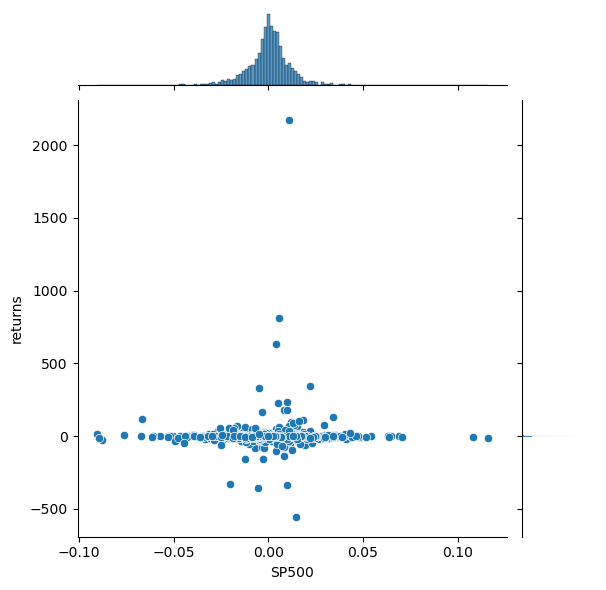

In [51]:
daily_returns = data.pct_change()
sns.jointplot(x='SP500', y='returns', data=daily_returns);

Pandas allow you to calculate all pairwise correlation coefficients with a single method called dot-corr. Apply it to the returns DataFrame, and you get a new DataFrame with the pairwise coefficients. The data are naturally symmetric around the diagonal, which contains only values of 1 because the correlation of a variable with itself is of course 1.

In [52]:
correlations = daily_returns.corr()
correlations

,SP500,returns,SP500_random
SP500,1.000000,0.023705,0.002456
returns,0.023705,1.000000,0.005190
SP500_random,0.002456,0.005190,1.000000


Seaborn again offers a neat tool to visualize pairwise correlation coefficients. The heatmap takes the DataFrame with the correlation coefficients as inputs and visualizes each value on a color scale that reflects the range of relevant values. The parameter annot equals True ensures that the values of the correlation coefficients are displayed as well. You can see that the correlations of daily returns among the various asset classes vary quite a bit.

# 4. Putting it all together: Building a value-weighted index
This chapter combines the previous concepts by teaching you how to create a value-weighted index. This index uses market-cap data contained in the stock exchange listings to calculate weights and 2016 stock price information. Index performance is then compared against benchmarks to evaluate the performance of the index you created.

To build a value-based index, you will take several steps: You will select the largest company from each sector using actual stock exchange data as index components. Then, you’ll calculate the number of shares for each company, and select the matching stock price series from a file. Next, you’ll compute the weights for each company, and based on these the index for each period. You will also evaluate and compare the index performance.

## 4.1 Select index components & import data
First, let’s import company data using pandas’ read_excel function. You will import this worksheet with listing info from a particular exchange while making sure missing values are properly recognized

In [53]:
# Load stock listing data
nyse = pd.read_excel('/kaggle/input/listings/listings.xlsx', 2, na_values='n/a')
nyse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stock Symbol           3147 non-null   object 
 1   Company Name           3147 non-null   object 
 2   Last Sale              3079 non-null   float64
 3   Market Capitalization  3147 non-null   float64
 4   IPO Year               1361 non-null   float64
 5   Sector                 2177 non-null   object 
 6   Industry               2177 non-null   object 
dtypes: float64(3), object(4)
memory usage: 172.2+ KB


/opt/conda/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Next, move the stock ticker into the index. Since you’ll select the largest company from each sector, remove companies without sector information. You can use the ‘subset’ keyword to identify one or several columns to filter out missing values. You have already seen the keyword ‘inplace’ to avoid creating a copy of the DataFrame. Finally, divide the market capitalization by 1 million to express the values in million USD. The results are 2177 companies from the NYSE stock exchange.

In [54]:
# prepare stock listing data
nyse.set_index('Stock Symbol', inplace=True)
nyse.dropna(subset=['Sector'], inplace=True)
nyse['Market Capitalization'] /= 1e6 # in Million USD

To pick the largest company in each sector, group these companies by sector, select the column market capitalization and apply the method nlargest with parameter 1. The result is a Series with the market cap in millions with a MultiIndex.

In [55]:
# Select index components
components = nyse.groupby(['Sector'])['Market Capitalization'].nlargest(1)
components.sort_values(ascending=False)

Sector                 Stock Symbol
Health Care            JNJ             338834.390080
Energy                 XOM             338728.713874
Finance                JPM             300283.250479
Miscellaneous          BABA            275525.000000
Public Utilities       T               247339.517272
Basic Industries       PG              230159.644117
Consumer Services      WMT             221864.614129
Consumer Non-Durables  KO              183655.305119
Technology             ORCL            181046.096000
Capital Goods          TM              155660.252483
Transportation         UPS              90180.886756
Consumer Durables      ABB              48398.935676
Name: Market Capitalization, dtype: float64

The first index level contains the sector, and the second is the stock ticker. To select the tickers from the second index level, select the series index, and apply the method ‘get_level_values’ with the name of the index ‘Stock Symbol’. You can also use the value 1 to select the second index level. Print the tickers, and you see that the result is a single DataFrame index. Use the method dot-tolist to obtain the result as a list.

In [56]:
tickers = components.index.get_level_values('Stock Symbol')
tickers
tickers.tolist()

['PG',
 'TM',
 'ABB',
 'KO',
 'WMT',
 'XOM',
 'JPM',
 'JNJ',
 'BABA',
 'T',
 'ORCL',
 'UPS']

Finally, use the ticker list to select your stocks from a broader set of recent price time series imported using read_csv.

In [57]:
tickers = components.index.get_level_values('Stock Symbol')
tickers
tickers.tolist()

['PG',
 'TM',
 'ABB',
 'KO',
 'WMT',
 'XOM',
 'JPM',
 'JNJ',
 'BABA',
 'T',
 'ORCL',
 'UPS']

## 4.2 Build a market-cap weighted index

To construct the market-cap weighted index, you need to calculate the number of shares using both market capitalization and the latest stock price, because the market capitalization is just the product of the number of shares and the price of each share. Next, you’ll use the historical stock prices to convert them into a series of market values. Then convert it to an index by normalizing the series to start at 100. You’ll also take a look at the index return and the contribution of each component to the result.

To calculate the number of shares, just divide the market capitalization by the last price. Since we are measuring market cap in million USD, you obtain the shares in millions as well. You can now multiply your historical stock price series by the number of shares.

In [58]:
shares = nyse['Market Capitalization'].div(nyse['Last Sale'])
data = pd.read_csv('/kaggle/input/stocks/stocks.csv', parse_dates=['Date'], index_col='Date').loc[:, tickers.tolist()]
market_cap_series = data.mul(len(shares))
market_cap_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PG      1761 non-null   float64
 1   TM      1762 non-null   float64
 2   ABB     1761 non-null   float64
 3   KO      1762 non-null   float64
 4   WMT     1762 non-null   float64
 5   XOM     1762 non-null   float64
 6   JPM     1762 non-null   float64
 7   JNJ     1762 non-null   float64
 8   BABA    1762 non-null   float64
 9   T       1762 non-null   float64
 10  ORCL    1761 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB


The result is a time series of the market capitalization, ie, the stock market value of each company. By selecting the first and the last day from this series, you can compare how each company’s market value has evolved over the year.

In [59]:
# From stock prices to market value
market_cap_series.first('D').append(market_cap_series.last('D'))

,PG,TM,ABB,KO,WMT,XOM,JPM,JNJ,BABA,T,ORCL,UPS
Date,,,,,,,,,,,,
2010-01-04,9905.35,121977.31,291500.30,376795.16,55905.36,150539.55,93284.45,140808.36,58779.00,62153.35,66550.89,126657.86
2016-12-30,30151.45,83727.42,1632466.99,521282.65,224775.25,196496.02,187853.33,250812.17,70295.33,20028.40,252140.14,249571.28


Now you almost have your index: just get the market value for all companies per period using the sum method with the parameter axis equals 1 to sum each row.



<AxesSubplot:title={'center':'Aggregate Market Cap'}, xlabel='Date'>

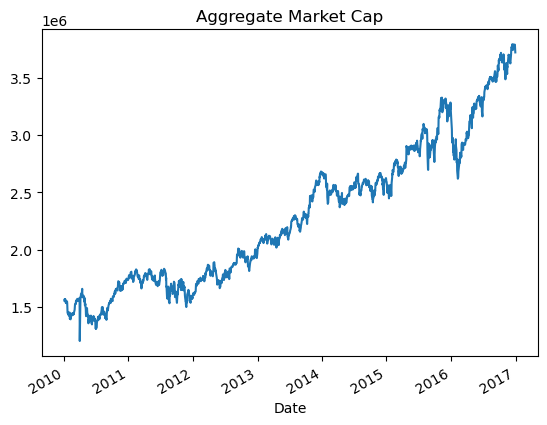

In [60]:
# Aggregate market value per period
agg_mcap = market_cap_series.sum(axis=1) # Total market cap
agg_mcap.plot(title='Aggregate Market Cap')

Now you just need to normalize this series to start at 1 by dividing the series by its first value, which you get using dot-iloc. Multiply the result by 100 and you get the convenient start value of 100 where differences from the start values are changes in percentage terms.



<AxesSubplot:title={'center':'Market-Cap Weighted Index'}, xlabel='Date'>

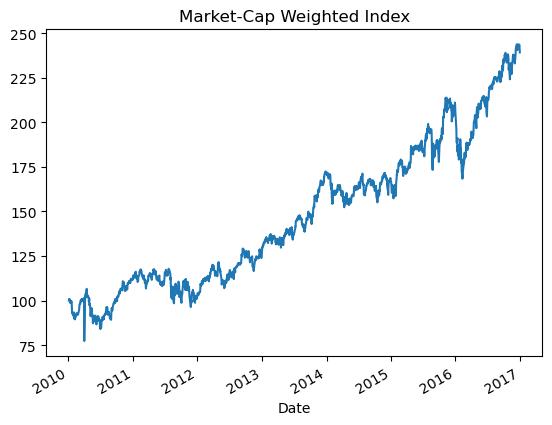

In [61]:
# Value-based index
index = agg_mcap.div(agg_mcap.iloc[0]).mul(100) # Divide by 1st value
index.plot(title='Market-Cap Weighted Index')

## 4.3. Evaluate index performance
Now that you have built a weighted index, you can analyze its performance. Important elements of your analysis will be: First, take a look at the index return, and the contribution of each component to the result. Next, compare the performance of your index to a benchmark like the S&P 500, which covers the wider market, and is also value-weighted. You can compare the overall performance or rolling returns for sub-periods.

First, let’s look at the contribution of each stock to the total value-added over the year. Subtract the last value of the aggregate market cap from the first to see that the companies in the index added 315 billion dollars in market cap. To see how much each company contributed to the total change, apply the diff method to the last and first value of the series of market capitalization per company and period. The last row now contains the total change in market cap since the first day. You can select the last row using dot-loc and the date pertaining to the last row, or iloc with the parameter -1.



In [62]:
# Value contribution by stock
change = market_cap_series.first('D').append(market_cap_series.last('D'))
change.diff().iloc[-1].sort_values() # or: .loc['2016-12-30']

T        -42124.95
TM       -38249.89
BABA      11516.33
PG        20246.10
XOM       45956.47
JPM       94568.88
JNJ      110003.81
UPS      122913.42
KO       144487.49
WMT      168869.89
ORCL     185589.25
ABB     1340966.69
Name: 2016-12-30 00:00:00, dtype: float64

To compute the contribution of each component to the index return, let’s first calculate the component weights. Select the market capitalization for the index components. Calculate the component weights by dividing their market cap by the sum of the market cap of all components. As you can see, the weights vary between 2 and 13%. Now calculate the total index return by dividing the last index value by the first value, subtracting 1, and multiplying by 100.

In [63]:
# Market-cap based weights
market_cap = nyse['Market Capitalization']
weights = market_cap.div(market_cap.sum())
weights.sort_values().mul(100)

Stock Symbol
KTP      0.000000
AEUA     0.000000
DTJ      0.000000
DTQ      0.000000
RBS^F    0.000000
           ...   
GE       0.992098
BABA     1.061835
JPM      1.157250
XOM      1.305414
JNJ      1.305821
Name: Market Capitalization, Length: 2177, dtype: float64

Let’s now move on and compare the composite index performance to the S&P 500 for the same period. Convert the index series to a DataFrame so you can insert a new column. Import the data from the Federal Reserve as before. Then normalize the S&P 500 to start at 100 just like your index, and insert as a new column, then plot both time series. You can see that your index did a couple of percentage points better for the period.

<AxesSubplot:xlabel='Date'>

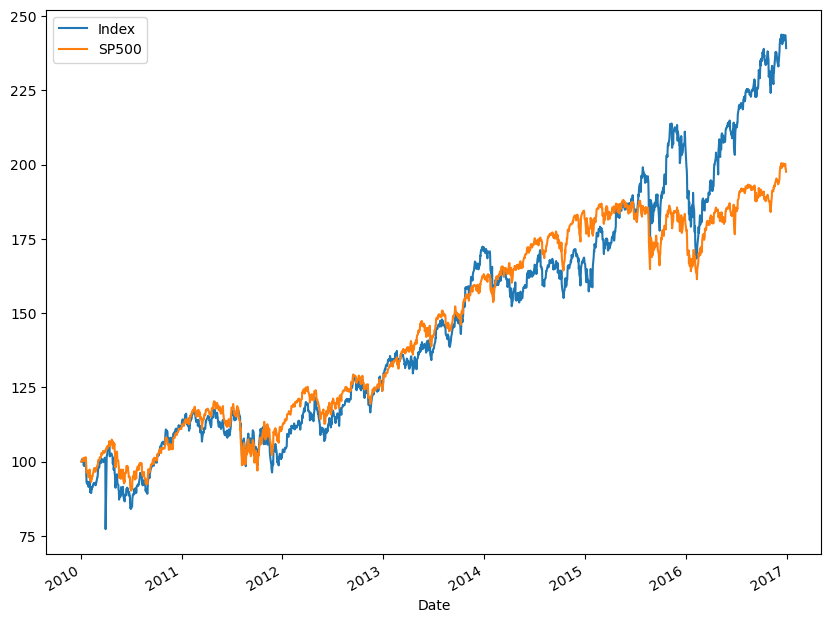

In [64]:
# Performance vs benchmark
data = index.to_frame('Index') # Convert pd.Series to pd.DataFrame

data['SP500'] = pd.read_csv('/kaggle/input/sp500-data/sp500.csv', parse_dates=['date'], index_col='date')

data.SP500 = data.SP500.div(data.SP500.iloc[0], axis=0).mul(100)
data.plot(figsize=(10,8))

Lastly, to compare the performance over various subperiods, create a multi-period-return function that compounds a NumPy array of period returns to a multi-period return as you did in chapter 3. Create the daily returns of your index and the S&P 500, a 30 calendar day rolling window, and apply your new function. The plot shows all 30-day returns for either series and illustrates when it was better to be invested in your index or the S&P 500 for a 30-day period.

<AxesSubplot:xlabel='Date'>

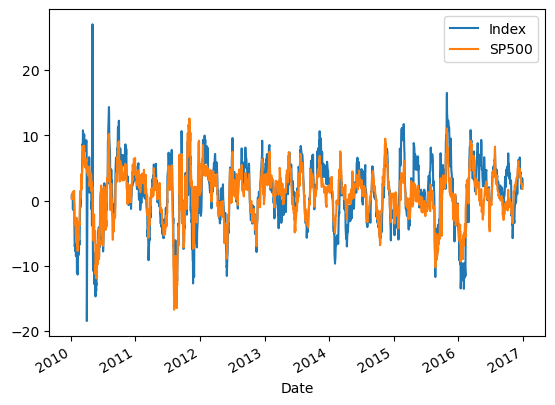

In [65]:
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100
data.pct_change().rolling('30D').apply(multi_period_return).plot()